In [7]:
import sys

In [8]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [9]:
api_key = "pCRLPdf2lkjpRX9Uczpt2gVBb" 
api_secret = "G1Wv7sTLMYF3cr5LbL8S9uj2g2LFrdWp8X8t7Ft3sIpW0kbqgD" 
access_token = "100875722-7m5vhOzpw2LYrB7P8ISnTqtGYMMvVTqwx3X4EyJY" 
access_token_secret = "uPEymGiszhiJEVWD4Alo1pzMUJx1ymo3Fd4HWyRPRBN3r" 

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["DataWranglingDay2"]["Pence"]
col.count()

<ipython-input-9-a05559c632eb>:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  col.count()


2707

In [10]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=3000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        
        self.counter += 1
        
        
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
           
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["Pence",""
           ]


progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)


for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Tweets collected: 0
Total tweets in collection: 2707


<ipython-input-10-098845bc694b>:55: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  print("Total tweets in collection: %s" % col.count())


In [11]:
col.find_one()

{'_id': ObjectId('5f9bd99ed173a73674e59923'),
 'created_at': 'Fri Oct 30 09:15:05 +0000 2020',
 'id': 1322104728021422080,
 'id_str': '1322104728021422080',
 'text': 'RT @chefjoseandres: .@Mike_Pence job creation run last 11 years was thanks to @BarackObama @JoeBiden economic policies. You and @realDonald…',
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 3099644855,
  'id_str': '3099644855',
  'name': 'Wizard Of Westside',
  'screen_name': 'kergarin',
  'location': 'Gardena, CA',
  'url': None,
  'description': 'Private chef/professional astrologer/raconteur #WizardOfWestside',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 227,
  'friends_count': 816,
  'listed_count': 6,
  'favourites_cou

In [12]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)

dataset

,created_at,text,user,source,lang
0,Fri Oct 30 09:15:05 +0000 2020,RT @chefjoseandres: .@Mike_Pence job creation ...,@kergarin,"<a href=""http://twitter.com/download/android"" ...",en
1,Fri Oct 30 09:15:07 +0000 2020,RT @Bill43111: @realDonaldTrump Remember. We’r...,@azeeestor,"<a href=""http://twitter.com/download/android"" ...",en
2,Fri Oct 30 09:15:23 +0000 2020,@AlZiegs @TrumpWarRoom I guess that’s why the ...,@Doomz__Dayz,"<a href=""http://twitter.com/download/iphone"" r...",en
3,Fri Oct 30 09:15:23 +0000 2020,#VoteTrumpOut2020,@WoodpeckerM,"<a href=""https://mobile.twitter.com"" rel=""nofo...",und
4,Fri Oct 30 09:15:27 +0000 2020,"RT @Mike_Pence: On my way, Reno! Make America ...",@Avenger2Toxic,"<a href=""http://twitter.com/download/iphone"" r...",en
...,...,...,...,...,...
2702,Fri Oct 30 13:24:14 +0000 2020,RT @latimes: Harris is the target of far more ...,@staran1981,"<a href=""http://twitter.com/download/iphone"" r...",en
2703,Fri Oct 30 13:24:16 +0000 2020,RT @donwinslow: Dear @realDonaldTrump and @VP ...,@dinu01,"<a href=""http://twitter.com/download/iphone"" r...",en
2704,Fri Oct 30 13:24:16 +0000 2020,RT @Mike_Pence: https://t.co/E8AzCiJwu2,@capnbadonk,"<a href=""https://mobile.twitter.com"" rel=""nofo...",und
2705,Fri Oct 30 13:24:18 +0000 2020,@Stopzecar Je pence qui veut piqué alix hier i...,@mimicarey13,"<a href=""http://twitter.com/download/iphone"" r...",fr


In [13]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,rt,1860
1,pence,1287
2,the,1193
3,co,1154
4,https,1154
5,and,794
6,to,730
7,trump,718
8,is,635
9,of,481


<ipython-input-14-a8481ec67a37>:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.source_name = dataset.source.apply(get_source_name)


blackmetalgenerator           3
Tweetbot for iΟS              6
Cheap Bots, Done Quick!       6
Puujee Puje                   7
WordPress.com                 8
TweetDeck                    18
Twitter for iPad            157
Twitter Web App             613
Twitter for Android         714
Twitter for iPhone         1139
Name: source, dtype: int64

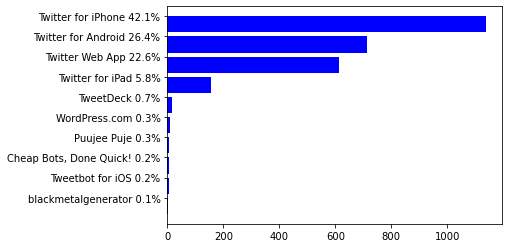

In [14]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

nl        3
tl        4
tr        4
es        9
fr       17
ja       26
pt       37
et       45
und     408
en     2147
Name: lang, dtype: int64

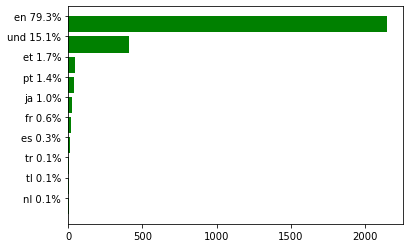

In [15]:
lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [16]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [17]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
0,1322104728021422080,RT @chefjoseandres: .@Mike_Pence job creation ...,en
1,1322104738377158658,RT @Bill43111: @realDonaldTrump Remember. We’r...,en
2,1322104802197856256,@AlZiegs @TrumpWarRoom I guess that’s why the ...,en
4,1322104820967374848,"RT @Mike_Pence: On my way, Reno! Make America ...",en
5,1322104842106642432,There are alternatives to massive FEDERAL spen...,en
...,...,...,...
2699,1322167423328538624,RT @chrissyteigen: this is...incredible,en
2700,1322167423588585472,"RT @azcentral: With time short, Vice President...",en
2701,1322167425035603975,@Mike_Pence really sucks at his job on the #Co...,en
2702,1322167430714662914,RT @latimes: Harris is the target of far more ...,en


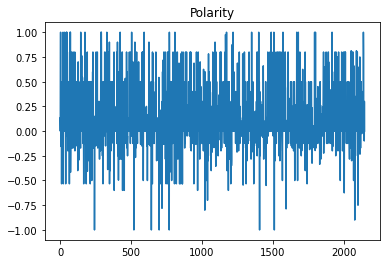

In [18]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

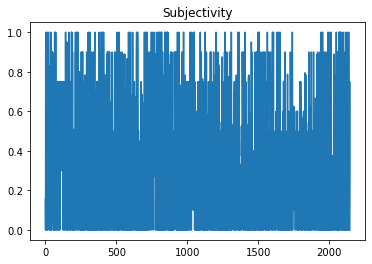

In [19]:
poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [20]:
import statistics
statistics.mean(poltweet.polarity)

0.1029304172367895

In [21]:
import statistics
statistics.mean(poltweet.subjectivity)

0.33295010368368544

In [22]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [23]:
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100


a = dataset1['text'].str.lower().str.cat(sep=' ')


b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


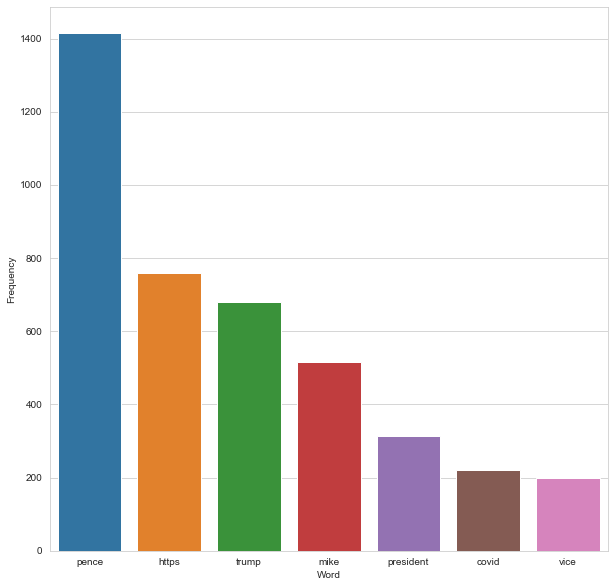

In [24]:
import seaborn as sns
 
without_single_chr = [word for word in filtered_sentence if len(word) > 2]


cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        


word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

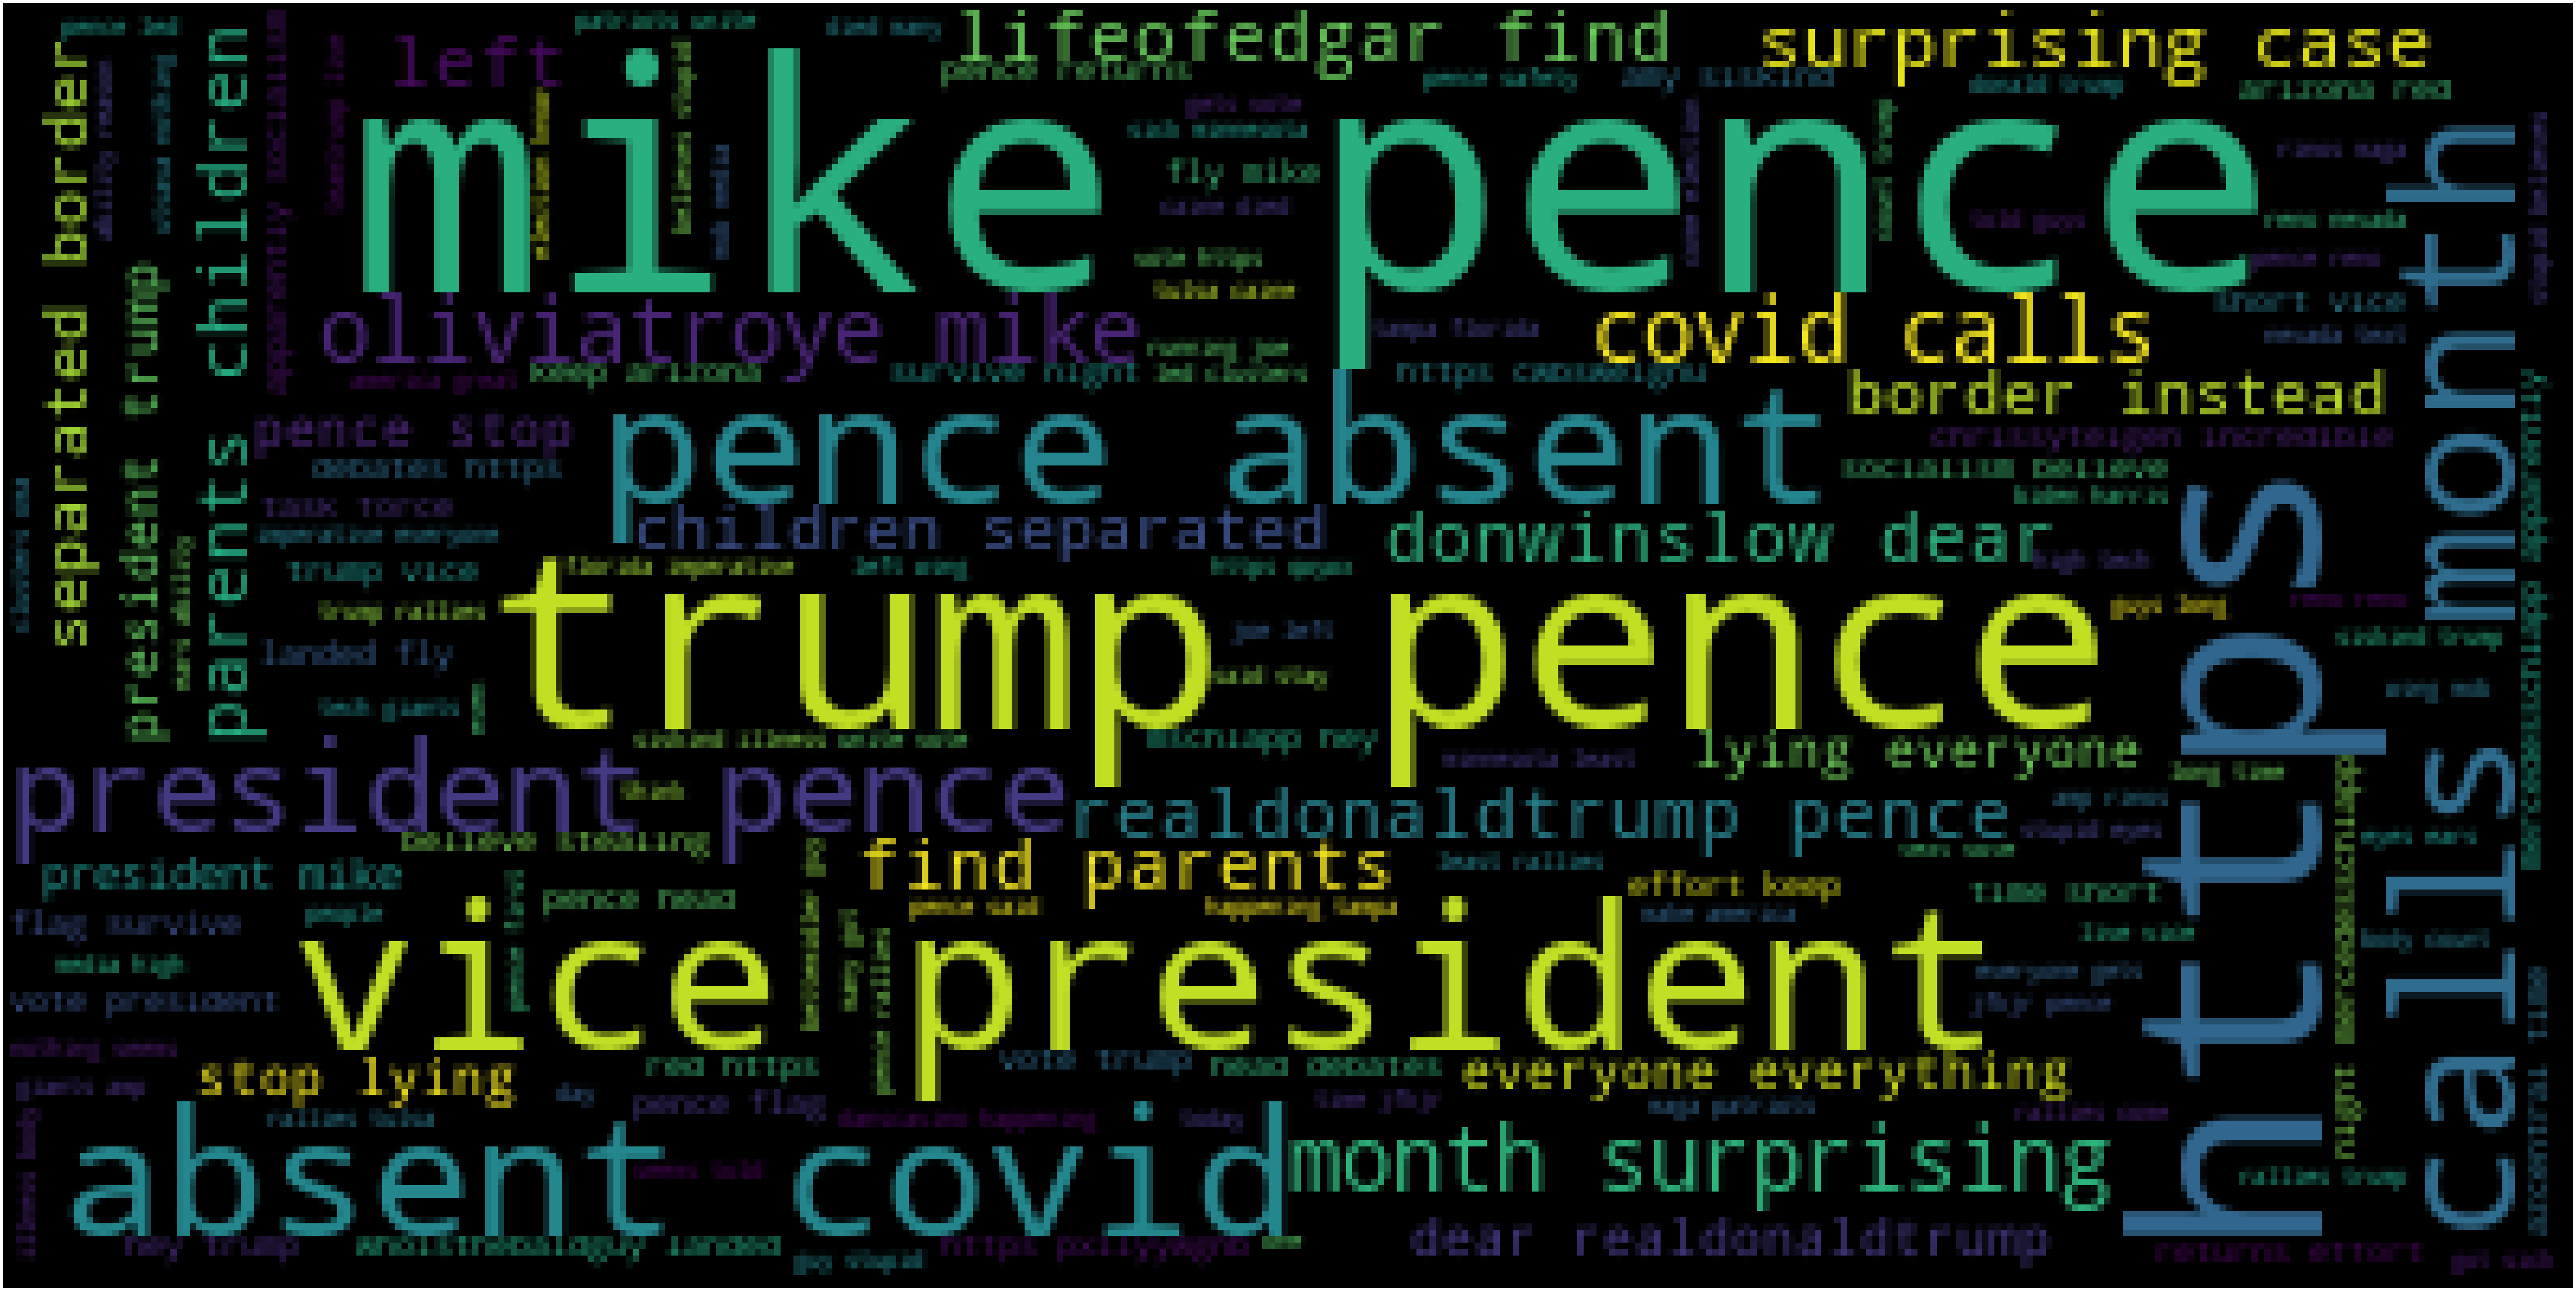

In [25]:
wc(cleaned_data_title,'black','Common Words' )

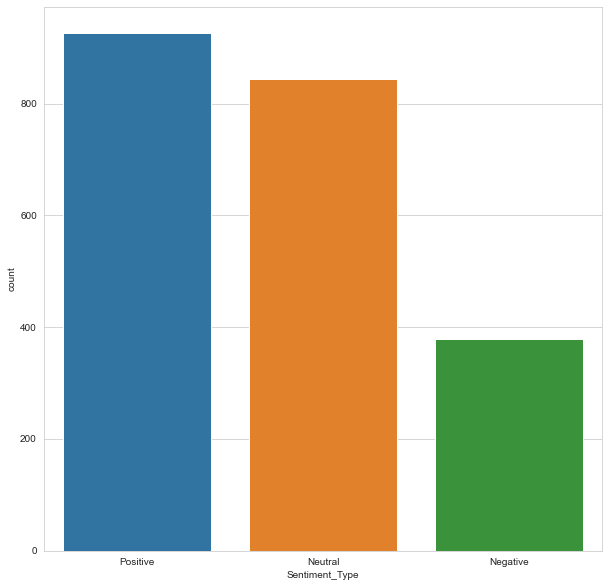

In [26]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=twit_polarity_desc)

In [27]:
import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'62.76'